# ACCESS-S2 sandbox

>9 June 2021<br>
>Thomas Moore

In [36]:
import xarray as xr
from dask_jobqueue import PBSCluster
from dask.distributed import Client
import numpy as np
import xrft
import scipy
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import os
import re
%config Completer.use_jedi = False

In [2]:
# supress warnings
import warnings
warnings.filterwarnings('ignore')

# Spin up a tiny little cluster with `dask-jobqueue`

### Specs for an individual worker

In [3]:
walltime = '02:00:00'
cores = 4
memory = '16GB'

cluster = PBSCluster(walltime=str(walltime), cores=cores, memory=str(memory),
                     job_extra=['-l ncpus='+str(cores),'-l mem='+str(memory),
                                '-l storage=gdata/v14+scratch/v14+gdata/lp01+scratch/lp01+scratch/ux06+gdata/rr3+gdata/al33+gdata/zv2+gdata/ux62'],
                     header_skip=["select"])

### Scale up to n workers

In [4]:
cluster.scale(jobs=5)

In [5]:
client = Client(cluster)

In [6]:
client

Client Scheduler: tcp://10.6.51.36:41735 Dashboard: http://10.6.51.36:38207/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


# ACCESS-S2 ocean reanalysis (RA) 1981 - 2018

In [7]:
root_path = '/g/data/ux62/access-s2/'
RA_ocean_path = '/g/data/ux62/access-s2/reanalysis/ocean/'
RA_ocean_variables_list = ['blt','d20','emp','hc300','mld1','mld2','salt','ssh','sss','sst','swflx','td','temp','thflx','u','v','w']
RA_ocean_variables_standard_keys = ['barrier_layer_thickness',
                           'depth_of_20C_isotherm',
                           'water_flux_out_of_sea_ice_and_sea_water',
                           'integral_of_sea_water_potential_temperature_wrt_depth_expressed_as_heat_content',
                           'ocean_mixed_layer_thickness_defined_by_sigma_theta_1',
                           'ocean_mixed_layer_thickness_defined_by_sigma_theta_2',
                           'sea_water_salinity',
                           'sea_surface_height_above_geoid',
                           'surface_sea_water_salinity',
                           'sea_water_potential_temperature',
                           'downwelling_photosynthetic_radiative_flux_in_sea_water',
                           'depth_at_maximum_upward_derivative_of_sea_water_potential_temperature',
                           'sea_water_potential_temperature',
                           'surface_downward_heat_flux_in_sea_water',
                           'sea_water_x_velocity',
                           'sea_water_y_velocity',
                           'sea_water_z_velocity']
RA_ocean_variables_long_keys = ['Barrier Layer Thickness',
                                'Depth of 20C isotherm',
                                'Net Upward Water Flux',
                                'Heat content 300 m',
                                'Kara Mixed Layer Depth',
                                'Mixed Layer Depth 0.01',
                                'Salinity',
                                'Sea Surface Height',
                                'Sea Surface Salinity',
                                'Sea Surface Temperature',
                                'Shortwave Radiation',
                                'Thermocline Depth',
                                'Temperature',
                                'Net Downward Heat Flux',
                                'Zonal Current',
                                'Meridional Current',
                                'Vertical Velocity']
RA_ocean_variables_period_dict = {'daily':'do','monthly':'mo'}
RA_ocean_variables_standard_dict = dict(zip(RA_ocean_variables_standard_keys, RA_ocean_variables_list))
RA_ocean_variables_long_dict = dict(zip(RA_ocean_variables_long_keys, RA_ocean_variables_list))

In [10]:
def make_ACCESS_S2_RA_path(period='monthly',variable_long_key ='Thermocline Depth'):
    RA_ocean_path = '/g/data/ux62/access-s2/reanalysis/ocean/'
    RA_ocean_variables_list = ['blt','d20','emp','hc300','mld1','mld2','salt','ssh','sss','sst','swflx','td','temp','thflx','u','v','w']
    RA_ocean_variables_standard_keys = ['barrier_layer_thickness',
                           'depth_of_20C_isotherm',
                           'water_flux_out_of_sea_ice_and_sea_water',
                           'integral_of_sea_water_potential_temperature_wrt_depth_expressed_as_heat_content',
                           'ocean_mixed_layer_thickness_defined_by_sigma_theta_1',
                           'ocean_mixed_layer_thickness_defined_by_sigma_theta_2',
                           'sea_water_salinity',
                           'sea_surface_height_above_geoid',
                           'surface_sea_water_salinity',
                           'sea_water_potential_temperature',
                           'downwelling_photosynthetic_radiative_flux_in_sea_water',
                           'depth_at_maximum_upward_derivative_of_sea_water_potential_temperature',
                           'sea_water_potential_temperature',
                           'surface_downward_heat_flux_in_sea_water',
                           'sea_water_x_velocity',
                           'sea_water_y_velocity',
                           'sea_water_z_velocity']
    RA_ocean_variables_long_keys = ['Barrier Layer Thickness',
                                'Depth of 20C isotherm',
                                'Net Upward Water Flux',
                                'Heat content 300 m',
                                'Kara Mixed Layer Depth',
                                'Mixed Layer Depth 0.01',
                                'Salinity',
                                'Sea Surface Height',
                                'Sea Surface Salinity',
                                'Sea Surface Temperature',
                                'Shortwave Radiation',
                                'Thermocline Depth',
                                'Temperature',
                                'Net Downward Heat Flux',
                                'Zonal Current',
                                'Meridional Current',
                                'Vertical Velocity']
    RA_ocean_variables_period_dict = {'daily':'do','monthly':'mo'}
    RA_ocean_variables_standard_dict = dict(zip(RA_ocean_variables_standard_keys, RA_ocean_variables_list))
    RA_ocean_variables_long_dict = dict(zip(RA_ocean_variables_long_keys, RA_ocean_variables_list))
    ACCESS_S2_RA_path = RA_ocean_path + RA_ocean_variables_long_dict[variable_long_key]+'/'+RA_ocean_variables_period_dict[period]+'_'+RA_ocean_variables_long_dict[variable_long_key]+'*'
    return ACCESS_S2_RA_path

In [11]:
make_ACCESS_S2_RA_path()

'/g/data/ux62/access-s2/reanalysis/ocean/td/mo_td*'

In [25]:
ds = xr.open_dataset('/g/data/ux62/access-s2/reanalysis/ocean/td/mo_td_1988.nc')
ds

<xarray.Dataset>
Dimensions:            (ncorners: 4, tbnds: 2, time_counter: 12, x: 1442, y: 1021)
Coordinates:
    nav_lat            (y, x) float32 ...
    nav_lon            (y, x) float32 ...
  * time_counter       (time_counter) datetime64[ns] 1988-01-16T12:00:00 ... ...
Dimensions without coordinates: ncorners, tbnds, x, y
Data variables:
    areat              (y, x) float32 ...
    latt_bounds        (y, x, ncorners) float32 ...
    lont_bounds        (y, x, ncorners) float32 ...
    td                 (time_counter, y, x) float32 ...
    time_counter_bnds  (time_counter, tbnds) datetime64[ns] ...
Attributes:
    Conventions:  CF-1.6
    production:   An IPSL model
    TimeStamp:    10/03/2019 15:58:07 -0000
    NCO:          netCDF Operators version 4.7.7 (Homepage = http://nco.sf.ne...
    history:      Tue Apr 16 00:38:33 2019: ncatted -a history,global,d,, mo_...

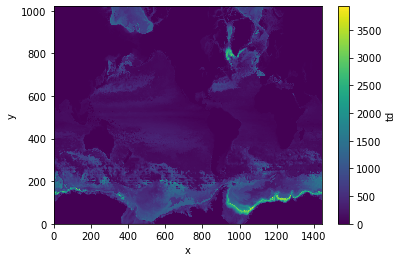

In [19]:
ds.td.max(dim='time_counter').plot()

In [20]:
make_ACCESS_S2_RA_path()

'/g/data/ux62/access-s2/reanalysis/ocean/td/mo_td*'

In [41]:
ds = xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/td/mo_td_19*.nc',parallel=True)
ds

<xarray.Dataset>
Dimensions:            (ncorners: 4, tbnds: 2, time_counter: 228, x: 1442, y: 1021)
Coordinates:
    nav_lat            (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
    nav_lon            (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
  * time_counter       (time_counter) datetime64[ns] 1981-01-16T12:00:00 ... ...
Dimensions without coordinates: ncorners, tbnds, x, y
Data variables:
    areat              (time_counter, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    latt_bounds        (time_counter, y, x, ncorners) float32 dask.array<chunksize=(12, 1021, 1442, 4), meta=np.ndarray>
    lont_bounds        (time_counter, y, x, ncorners) float32 dask.array<chunksize=(12, 1021, 1442, 4), meta=np.ndarray>
    td                 (time_counter, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    time_counter_bnds  (time_counter, tbnds) datetime64[ns] dask.array<chunksize=(12, 2), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    production:   An IPSL model
    TimeStamp:    12/09/2018 08:38:02 -0000
    NCO:          netCDF Operators version 4.7.7 (Homepage = http://nco.sf.ne...
    history:      Tue Apr  2 17:05:22 2019: ncatted -a history,global,d,, mo_...

In [47]:
file_list =[]
regexp = re.compile('mo_td_(201[0-8]).nc')
ROOT_DIR ='/g/data/ux62/access-s2/reanalysis/ocean/td/'
for root, dirs, files in os.walk(ROOT_DIR):
    for file in files:
        if regexp.search(file):
            file_list.append(os.path.join(root, file))

file_list.sort()
file_list

['/g/data/ux62/access-s2/reanalysis/ocean/td/mo_td_2010.nc',
 '/g/data/ux62/access-s2/reanalysis/ocean/td/mo_td_2011.nc',
 '/g/data/ux62/access-s2/reanalysis/ocean/td/mo_td_2012.nc',
 '/g/data/ux62/access-s2/reanalysis/ocean/td/mo_td_2013.nc',
 '/g/data/ux62/access-s2/reanalysis/ocean/td/mo_td_2014.nc',
 '/g/data/ux62/access-s2/reanalysis/ocean/td/mo_td_2015.nc',
 '/g/data/ux62/access-s2/reanalysis/ocean/td/mo_td_2016.nc',
 '/g/data/ux62/access-s2/reanalysis/ocean/td/mo_td_2017.nc',
 '/g/data/ux62/access-s2/reanalysis/ocean/td/mo_td_2018.nc']

In [48]:
ds_2010_2018 = xr.open_mfdataset(file_list,parallel=True)
ds_2010_2018

<xarray.Dataset>
Dimensions:            (ncorners: 4, tbnds: 2, time_counter: 108, x: 1442, y: 1021)
Coordinates:
  * time_counter       (time_counter) datetime64[ns] 2010-01-16T12:00:00 ... ...
    nav_lat            (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
    nav_lon            (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
Dimensions without coordinates: ncorners, tbnds, x, y
Data variables:
    areat              (time_counter, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    latt_bounds        (time_counter, y, x, ncorners) float32 dask.array<chunksize=(12, 1021, 1442, 4), meta=np.ndarray>
    lont_bounds        (time_counter, y, x, ncorners) float32 dask.array<chunksize=(12, 1021, 1442, 4), meta=np.ndarray>
    td                 (time_counter, y, x) float32 dask.array<chunksize=(108, 1021, 1442), meta=np.ndarray>
    time_counter_bnds  (time_counter, tbnds) datetime64[ns] dask.array<chunksize=(108, 2), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    production:   An IPSL model
    TimeStamp:    04/05/2019 21:24:59 -0000
    NCO:          netCDF Operators version 4.7.7 (Homepage = http://nco.sf.ne...
    history:      Mon May 20 18:15:02 2019: ncatted -a history,global,d,, mo_...

In [49]:
file_list =[]
regexp = re.compile('mo_td_(198[1-9]|199[0-9]|200[0-9]).nc')
ROOT_DIR ='/g/data/ux62/access-s2/reanalysis/ocean/td/'
for root, dirs, files in os.walk(ROOT_DIR):
    for file in files:
        if regexp.search(file):
            file_list.append(os.path.join(root, file))

file_list.sort()
file_list

['/g/data/ux62/access-s2/reanalysis/ocean/td/mo_td_1981.nc',
 '/g/data/ux62/access-s2/reanalysis/ocean/td/mo_td_1982.nc',
 '/g/data/ux62/access-s2/reanalysis/ocean/td/mo_td_1983.nc',
 '/g/data/ux62/access-s2/reanalysis/ocean/td/mo_td_1984.nc',
 '/g/data/ux62/access-s2/reanalysis/ocean/td/mo_td_1985.nc',
 '/g/data/ux62/access-s2/reanalysis/ocean/td/mo_td_1986.nc',
 '/g/data/ux62/access-s2/reanalysis/ocean/td/mo_td_1987.nc',
 '/g/data/ux62/access-s2/reanalysis/ocean/td/mo_td_1988.nc',
 '/g/data/ux62/access-s2/reanalysis/ocean/td/mo_td_1989.nc',
 '/g/data/ux62/access-s2/reanalysis/ocean/td/mo_td_1990.nc',
 '/g/data/ux62/access-s2/reanalysis/ocean/td/mo_td_1991.nc',
 '/g/data/ux62/access-s2/reanalysis/ocean/td/mo_td_1992.nc',
 '/g/data/ux62/access-s2/reanalysis/ocean/td/mo_td_1993.nc',
 '/g/data/ux62/access-s2/reanalysis/ocean/td/mo_td_1994.nc',
 '/g/data/ux62/access-s2/reanalysis/ocean/td/mo_td_1995.nc',
 '/g/data/ux62/access-s2/reanalysis/ocean/td/mo_td_1996.nc',
 '/g/data/ux62/access-s2

In [50]:
ds_1981_2009 = xr.open_mfdataset(file_list,parallel=True)
ds_1981_2009

<xarray.Dataset>
Dimensions:            (ncorners: 4, tbnds: 2, time_counter: 348, x: 1442, y: 1021)
Coordinates:
    nav_lat            (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
    nav_lon            (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
  * time_counter       (time_counter) datetime64[ns] 1981-01-16T12:00:00 ... ...
Dimensions without coordinates: ncorners, tbnds, x, y
Data variables:
    areat              (time_counter, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    latt_bounds        (time_counter, y, x, ncorners) float32 dask.array<chunksize=(12, 1021, 1442, 4), meta=np.ndarray>
    lont_bounds        (time_counter, y, x, ncorners) float32 dask.array<chunksize=(12, 1021, 1442, 4), meta=np.ndarray>
    td                 (time_counter, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    time_counter_bnds  (time_counter, tbnds) datetime64[ns] dask.array<chunksize=(12, 2), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    production:   An IPSL model
    TimeStamp:    12/09/2018 08:38:02 -0000
    NCO:          netCDF Operators version 4.7.7 (Homepage = http://nco.sf.ne...
    history:      Tue Apr  2 17:05:22 2019: ncatted -a history,global,d,, mo_...

In [52]:
ds = xr.merge([ds_1981_2009,ds_2010_2018])

KilledWorker: ("('array-de8d81beee2b6f1afbca669a940cb469', 0, 0, 0)", <WorkerState 'tcp://10.6.66.5:33515', name: 3-0, memory: 0, processing: 1>)

In [53]:
make_ACCESS_S2_RA_path(variable_long_key ='Heat content 300 m')

'/g/data/ux62/access-s2/reanalysis/ocean/hc300/mo_hc300*'

In [ ]:
xr.open_mfdataset(make_ACCESS_S2_RA_path(variable_long_key ='Heat content 300 m'),parallel=True)